In [1]:
import torch as t
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable as V

from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random
import string

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 1. Data

In [2]:
characters = string.digits + string.ascii_uppercase
print(characters)

0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ


In [20]:
# 默认设置
width, height, n_len, n_class = 170, 80, 4, len(characters)
lr = 0.01
batch_size = 32
num_test = 1000
num_iters = 1000

print_every = 100

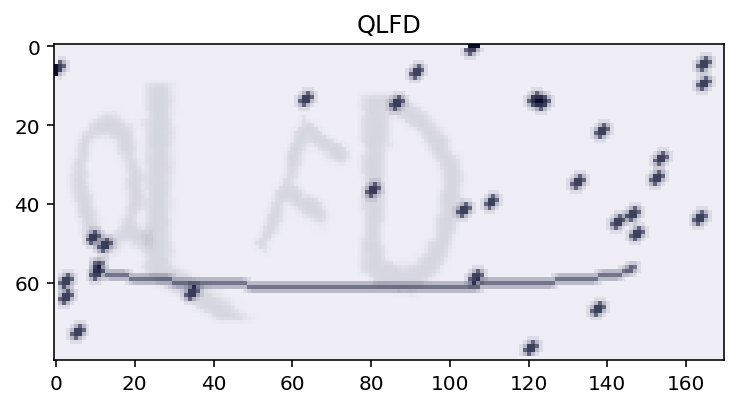

In [4]:
# 创建一个生成器 -> 随机生成字符 -> 使用生成器生成字符对应的 image
generator = ImageCaptcha(width=width, height=height)
random_str = ''.join([random.choice(characters) for j in range(4)])
img = generator.generate_image(random_str)

plt.imshow(img);
plt.title(random_str);

In [5]:
# X shape of (batch_size, height, width, channels)
# y is a list of [(batch_size,)], list length is num_labels

def gen(batch_size=32):
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
    # y = np.zeros((batch_size, n_len, n_class), dtype=np.uint8)
    y = [np.zeros(batch_size, dtype=np.uint8) for i in range(n_len)]
    generator = ImageCaptcha(width=width, height=height)
    while True:
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(4)])
            X[i] = generator.generate_image(random_str)
            for j, ch in enumerate(random_str):
                y[j][i] = characters.find(ch)
        yield X, y

In [7]:
# 生成验证集
test_generator = gen(num_test)
X_test, [y_test_1, y_test_2, y_test_3, y_test_4] = next(test_generator)
print(X_test.shape)
print(y_test_1.shape)

(1000, 80, 170, 3)
(1000,)


(32, 4)


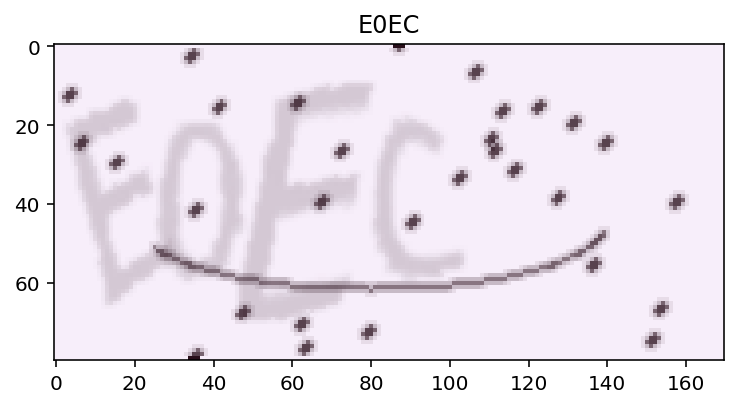

In [11]:
# 因为模型生成的y是一个概率，需要一个由字符概率生成对应字符的过程， 称为 decode
# decode 只是为了将 image 和对应的label 画出来
def decode(y_list):
    z = np.squeeze(np.transpose(np.array([y_list])))
    print(z.shape)
    z = z[0]
    return ''.join([characters[i] for i in z])

X, [y_1, y_2, y_3, y_4] = next(gen(32))
plt.imshow(X[0]);
plt.title(decode([y_1, y_2, y_3, y_4]));

## 2.Model

In [12]:
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv1_1 = nn.Conv2d(3, 32, (3,3))
        self.conv1_2 = nn.Conv2d(32, 32, (3,3))
        self.maxpool_1 = nn.MaxPool2d((2,2))
        
        self.conv2_1 = nn.Conv2d(32, 64, (3,3))
        self.conv2_2 = nn.Conv2d(64, 64, (3,3))
        self.maxpool_2 = nn.MaxPool2d((2,2))
        
        self.conv3_1 = nn.Conv2d(64, 128, (3,3))
        self.conv3_2 = nn.Conv2d(128, 128, (3,3))
        self.maxpool_3 = nn.MaxPool2d((2,2))
        
        self.conv4_1 = nn.Conv2d(128, 256, (3,3))
        self.conv4_2 = nn.Conv2d(256, 256, (3,3))
        self.maxpool_4 = nn.MaxPool2d((2,2))
        
        self.dropout = nn.Dropout(p=0.5)
        
        self.dense_1 = nn.Linear(256*6, 36)
        self.dense_2 = nn.Linear(256*6, 36)    
        self.dense_3 = nn.Linear(256*6, 36)
        self.dense_4 = nn.Linear(256*6, 36)
            
    def forward(self, x):
        x = self.conv1_1(x)
        x = self.conv1_2(x)
        x = self.maxpool_1(x)
        
        x = self.conv2_1(x)
        x = self.conv2_2(x)
        x = self.maxpool_2(x)
        
        x = self.conv3_1(x)
        x = self.conv3_2(x)
        x = self.maxpool_3(x)
        
        x = self.conv4_1(x)
        x = self.conv4_2(x)
        x = self.maxpool_4(x)
             
        x = x.view(-1, 256*6)
        
        x = self.dropout(x)
        
        # out_1 = F.softmax(self.dense_1(x), dim=1)
        # out_2 = F.softmax(self.dense_2(x), dim=1)
        # out_3 = F.softmax(self.dense_3(x), dim=1)
        # out_4 = F.softmax(self.dense_4(x), dim=1)
        
        out_1 = self.dense_1(x)
        out_2 = self.dense_2(x)
        out_3 = self.dense_3(x)
        out_4 = self.dense_4(x)
                                
        out = [out_1, out_2, out_3, out_4]
        return out

In [13]:
model = Model()

In [14]:
x = t.tensor(X).permute(0,3,1,2).float()
print(x.shape)
[out_1, out_2, out_3, out_4] = model(x)
print(out_1.shape)

torch.Size([32, 3, 80, 170])
torch.Size([32, 36])


## 3. Training

In [27]:
def eval(model, X_test, y_tests):
    
    X_test = t.tensor(X_test).permute(0,3,1,2).float()
    y_tests = np.transpose(np.array(y_tests))
    
    [out_1, out_2, out_3, out_4] = model(X_test)
    
    outs = []
    for out in [out_1, out_2, out_3, out_4]:
        outs.append(np.argmax(out, axis=1))
    
    outs = np.transpose(np.array(outs))
    
    right = 0
    for i in range(outs.shape[0]):
        if outs[i,:] == y_tests[i,:]:
            right += 1
        
    return right/outs.shape[0]

In [15]:
def toVariables(v_list):
    return [V(t.tensor(v)).long() for v in v_list]

In [19]:
# output shape of (batch_size, num_class)
# target shape og (batch_size,), every element of target is a class index
criterion = nn.CrossEntropyLoss()

optimizer = t.optim.Adam(model.parameters(), lr=lr)

In [33]:
train_generator = gen(batch_size)

for iter in range(num_iters):
    
    X, [y_1, y_2, y_3, y_4] = next(train_generator) 
    [y_1, y_2, y_3, y_4] = toVariables([y_1, y_2, y_3, y_4])
    
    x = t.tensor(X).permute(0,3,1,2).float()
    [out_1, out_2, out_3, out_4] = model(x)
    
    optimizer.zero_grad()
    loss = criterion(out_1, y_1) + loss(out_2, y_2) + loss(out_3, y_3) + loss(out_4, y_4)
    loss.backward()
    optimizer.step()
    
    if iter%print_every == 0:
        eval()

In [26]:
eval(model, X_test, [y_test_1, y_test_2, y_test_3, y_test_4])

RuntimeError: Given groups=1, weight[32, 3, 3, 3], so expected input[1000, 80, 170, 3] to have 3 channels, but got 80 channels instead